# Raport: Wykrywanie anomalii w rzeczywistych zbiorach danych

##### Wykonał: Andrii Sonsiadlo
##### Nr albumu: 245576


W celu przeprowadzenia eksperymentów z wykrywaniem anomalii, wybrano zbiory danych o różnych rozmiarach i wymiarach.
Statystyki opisowe dla każdego zbioru zostały przedstawione w następnej częci raportu.
Dla wykonania eksperymentów na wybranych metodach zbiory danych byli podzielone na zbiory treningowy i testowy w proporcji 1:1.

| Dataset | Description             | Size  |  DIM  | OOD           |
|---------|-------------------------|-------|:-----:|---------------|
| Thyroid | Thyroid disease         | 3772  |   6   | 93 (2.47 %)   |
| Shuttle | Shuttle landing control | 49097 |   9   | 3511 (7.15 %) |
| Vowels  | Vowels recognition      | 1456  |  12   | 50 (3.43 %)   |

Wykorzystane algorytmy do wykrywania anomalii:
- *Isolation Forest*
- *Local Outlier Factor*
- *Support Vector Machine*

Zastosowane metryki dla określenia jakości algorytmów:
- *Accuracy*
- *Precision*
- *Recall*
- *F1*
- *ROC (TPR, FPR)*
- *AUC*
- *Confusion Matrix*

Zbiory danych zostały pobrane z: [link](http://odds.cs.stonybrook.edu/)

### Importing libraries

In [216]:
%matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from typing import Optional

import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from pydantic import BaseModel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.svm import OneClassSVM


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuring pandas

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

### Loading datasets

In [3]:
from pydantic import Field


class DF(DataFrame):
    @classmethod
    def __get_validators__(cls):
        yield cls.validate

    @classmethod
    def validate(cls, v):
        if not isinstance(v, DataFrame):
            raise ValueError('Expected DataFrame from pandas')
        return v

    def __repr__(self):
        return f'DataFrame({super().__repr__()})'

    def __str__(self):
        return f'DataFrame({super().__str__()})'


class Dataset(BaseModel):
    class Config:
        arbitrary_types_allowed = True
        repr_html = True
        validate_assignment = True

    name: str
    x: DF = Field(repr=False)
    y: DF = Field(repr=False)

    x_train: Optional[DF]
    y_train: Optional[DF]
    x_test: Optional[DF]
    y_test: Optional[DF]

    y_pred: Optional[DF]
    scores_pred: Optional[DF]

    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.5,
                                                                                shuffle=True)
        return self

In [4]:
def load_datasets(dataset_names: tuple, verbose: bool = False):
    datasets = defaultdict(Dataset)
    for dataset_name in dataset_names:
        raw_data = scipy.io.loadmat(f'../datasets/{dataset_name}.mat')

        x = np.array(raw_data.get('X'))
        y = np.array(raw_data.get('y')).ravel().astype(dtype=np.uint8)

        # TODO: split into train and test dataset, use splitted datasets in experiments
        dataset = Dataset(
            name=dataset_name,
            x=DataFrame(x, columns=[f'x{i}' for i in range(1, x.shape[1] + 1)]),
            y=DataFrame(y, columns=["class"]),
        ).split_data()
        if verbose:
            print(
                f"Name: {dataset.name}\n"
                f"X: {dataset.x.shape}\n"
                f"Y: {dataset.y.shape}\n"
                f"OOD: {(ood := np.count_nonzero(dataset.y == 1))} ({round((ood * 100) / len(dataset.y), 2)} %)\n"
            )
        datasets[dataset_name] = dataset
    return datasets


DATASET_NAMES = ('thyroid', 'shuttle', 'vowels')
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=True)

Name: thyroid
X: (3772, 6)
Y: (3772, 1)
OOD: 93 (2.47 %)

Name: shuttle
X: (49097, 9)
Y: (49097, 1)
OOD: 3511 (7.15 %)

Name: vowels
X: (1456, 12)
Y: (1456, 1)
OOD: 50 (3.43 %)



### Statistics functions

In [5]:
def accuracy_report(dataset: Dataset):
    print("Accuracy Score :", accuracy_score(dataset.y_test, dataset.y_pred))
    print("Classification Report :\n", classification_report(dataset.y_test, dataset.y_pred))

In [6]:
def corr_map_plot(dataset: Dataset, figsize=(20, 20)):
    # get correlations of each features in dataset
    corrmat = dataset.x.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=figsize)
    plt.title(f"Correlation map for {dataset.name.capitalize()} dataset")
    #plot heat map
    g = sns.heatmap(dataset.x[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [7]:
def conf_matrix_plot(dataset: Dataset):
    cm = confusion_matrix(dataset.y_test, dataset.y_pred)
    df_cm = pd.DataFrame(cm, index = [0, 1],
                  columns = [0, 1])
    plt.figure(figsize = (4,4))
    s = sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    s.set(xlabel='Predicted label', ylabel='True label', title=f"Confusion matrix for {dataset.name.capitalize()} dataset")
    plt.show()
    # disp = ConfusionMatrixDisplay(cm)
    # disp.plot()
    # plt.title(f"Confusion matrix for {dataset.name.capitalize()} dataset")
    # plt.show()

In [43]:
def roc_curve_plot(datasets: dict[str, Dataset] | Dataset):
    if isinstance(datasets, Dataset):
        datasets = {datasets.name: datasets}

    plt.figure(figsize=(7,7))
    for name, dataset in datasets.items():
        fpr, tpr, thresh = roc_curve(dataset.y_test, dataset.scores_pred)
        auc = roc_auc_score(dataset.y_test, dataset.scores_pred)
        plt.plot(tpr, fpr, label=f"Dataset: {dataset.name}, auc={round(1 - auc, 3)}")

    plt.plot([0, 1], [0, 1], "k--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc=0)
    plt.show()

In [9]:
%matplotlib widget

def plot_3d(dataset: Dataset, dims: tuple[int, int, int]):
    x_index = dims[0]
    y_index = dims[1]
    z_index = dims[2]

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dataset.x.iloc[:, x_index], dataset.x.iloc[:, y_index], dataset.x.iloc[:, z_index], c=dataset.y, cmap='rainbow')
    ax.set_xlabel(dataset.x.columns[x_index])
    ax.set_ylabel(dataset.x.columns[y_index])
    ax.set_zlabel(dataset.x.columns[z_index])
    plt.show()

# Datasets

## Thyroid dataset

In [10]:
thyroid = datasets["thyroid"]
thyroid.x.head()

,x1,x2,x3,x4,x5,x6
0,0.774,1.132e-03,0.138,0.276,0.296,0.236
1,0.247,4.717e-04,0.280,0.329,0.535,0.174
2,0.495,3.585e-03,0.223,0.234,0.526,0.125
3,0.677,1.698e-03,0.157,0.175,0.333,0.136
4,0.237,4.717e-04,0.242,0.320,0.333,0.248


In [11]:
thyroid.x.describe()

,x1,x2,x3,x4,x5,x6
count,3772.000,3772.000,3772.000,3772.000,3772.000,3772.000
mean,0.543,0.009,0.187,0.248,0.377,0.177
std,0.204,0.044,0.070,0.081,0.087,0.055
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.376,0.001,0.157,0.203,0.329,0.149
50%,0.570,0.003,0.191,0.242,0.376,0.174
75%,0.710,0.005,0.213,0.283,0.413,0.197
max,1.000,1.000,1.000,1.000,1.000,1.000


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>]],
      dtype=object)

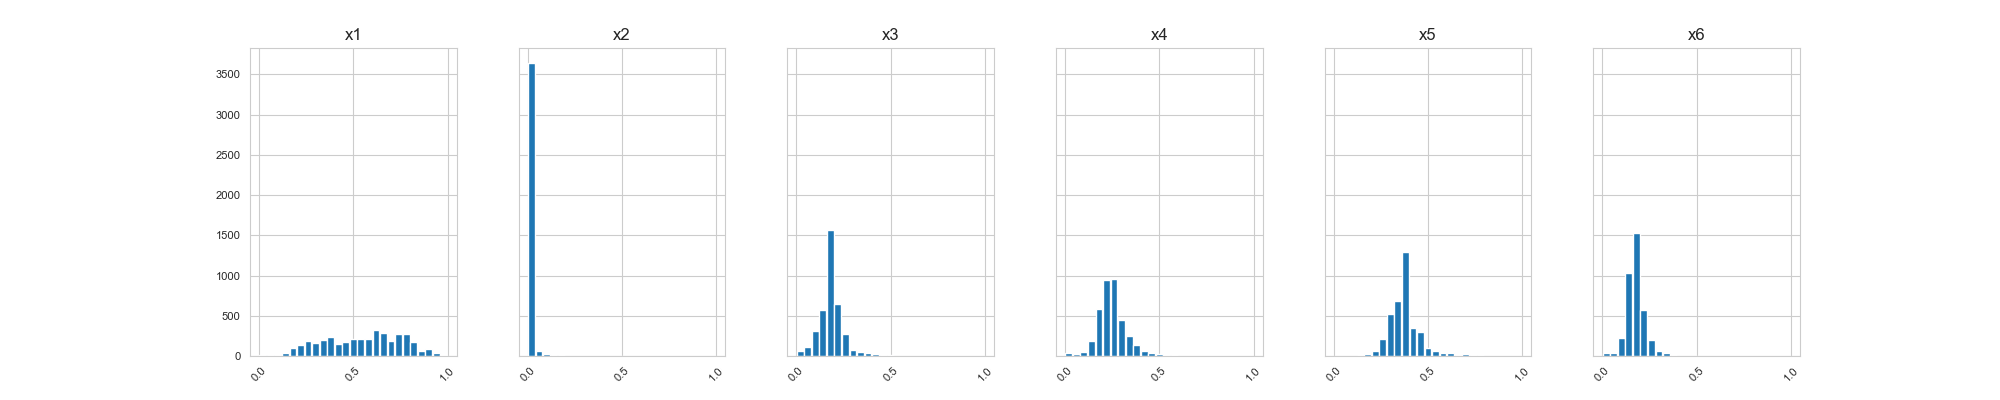

In [12]:
thyroid.x.hist(figsize=(20, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 6), sharey=True, zorder=2,
               rwidth=0.9)

In [13]:
thyroid.y.describe()

,class
count,3772.000
mean,0.025
std,0.155
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [14]:
thyroid.y.value_counts()

class
0        3679
1          93
Name: count, dtype: int64

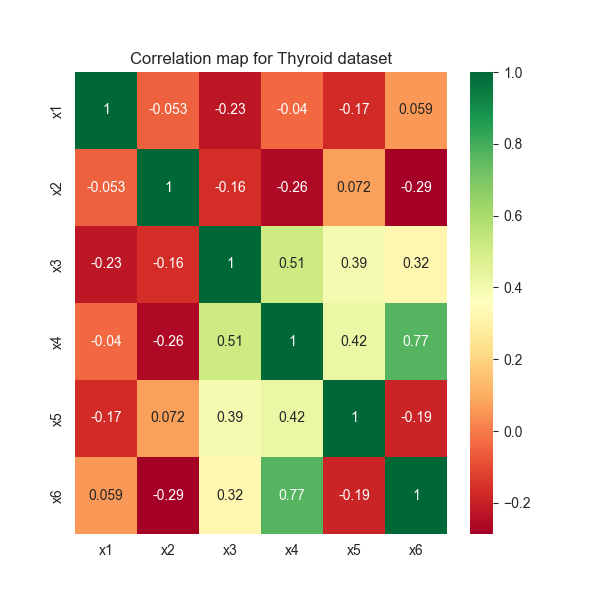

In [15]:
corr_map_plot(thyroid, figsize=(6, 6))

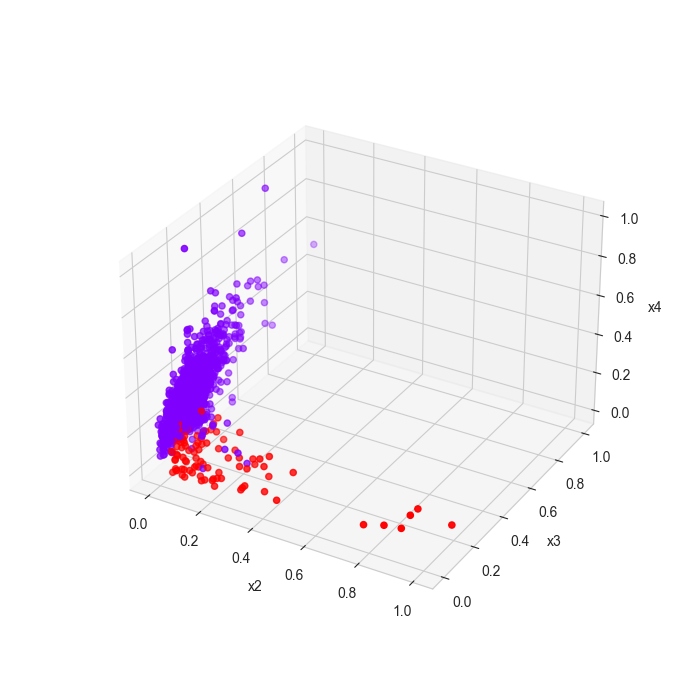

In [16]:
plot_3d(thyroid, dims=(1, 2, 3))

## Shuttle dataset

In [17]:
shuttle = datasets["shuttle"]
shuttle.x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,50,21,77,0,28,0,27,48,22
1,53,0,82,0,52,-5,29,30,2
2,37,0,76,0,28,18,40,48,8
3,37,0,79,0,34,-26,43,46,2
4,85,0,88,-4,6,1,3,83,80


In [18]:
shuttle.x.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9
count,49097.000,49097.000,49097.000,49097.000,49097.000,49097.000,49097.000,49097.000,49097.000
mean,46.932,-0.064,85.123,0.213,36.872,2.160,38.201,48.289,10.262
std,12.875,84.674,8.878,37.579,19.963,218.325,13.446,20.572,23.751
min,27.000,-4821.000,21.000,-3939.000,-188.000,-26739.000,-48.000,-353.000,-356.000
25%,37.000,0.000,79.000,0.000,30.000,-4.000,33.000,35.000,0.000
50%,44.000,0.000,83.000,0.000,42.000,0.000,39.000,41.000,2.000
75%,50.000,0.000,88.000,0.000,46.000,5.000,43.000,55.000,6.000
max,126.000,5075.000,149.000,3830.000,436.000,15164.000,105.000,270.000,266.000


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>,
        <Axes: title={'center': 'x7'}>, <Axes: title={'center': 'x8'}>,
        <Axes: title={'center': 'x9'}>]], dtype=object)

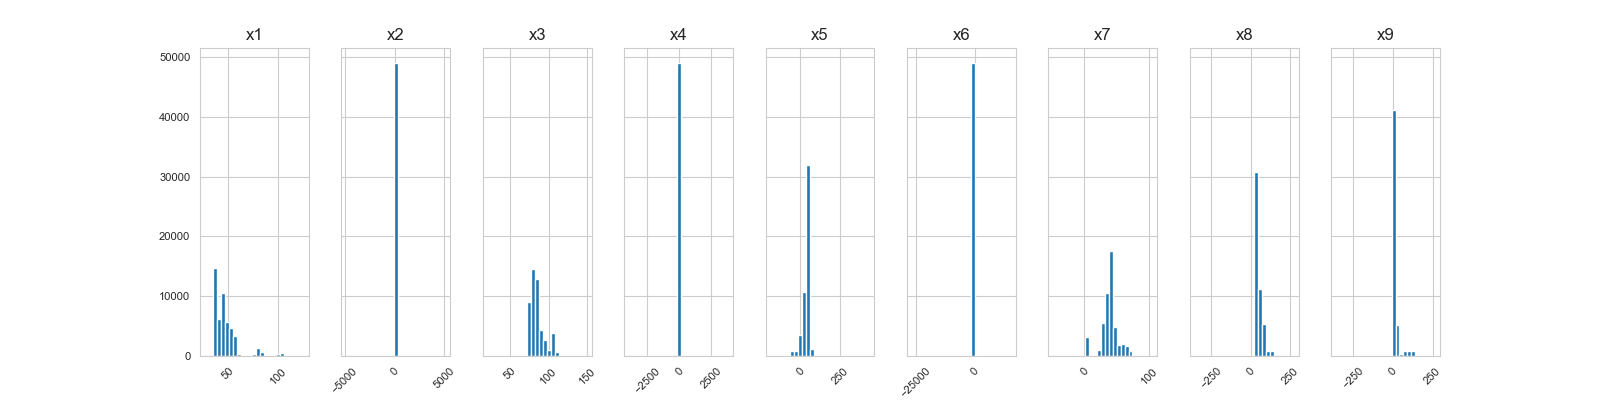

In [74]:
shuttle.x.hist(figsize=(16, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 9), sharey=True)

In [20]:
shuttle.y.describe()

,class
count,49097.000
mean,0.072
std,0.258
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [21]:
shuttle.y.value_counts()

class
0        45586
1         3511
Name: count, dtype: int64

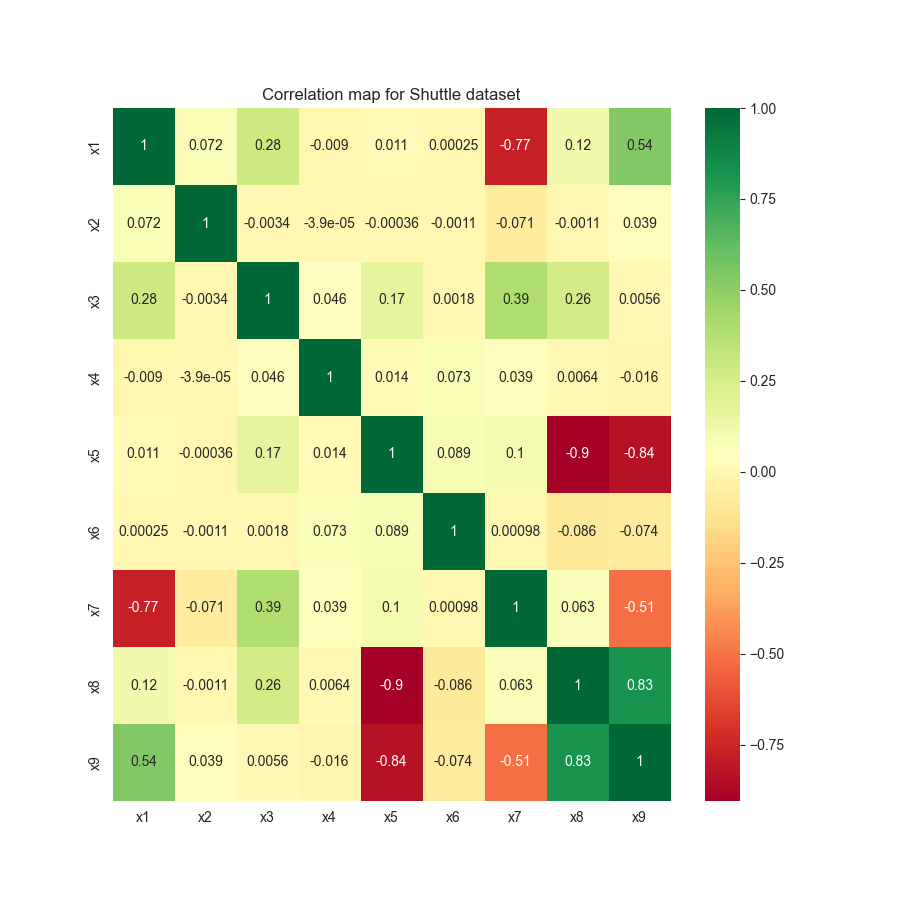

In [22]:
corr_map_plot(shuttle, figsize=(9, 9))

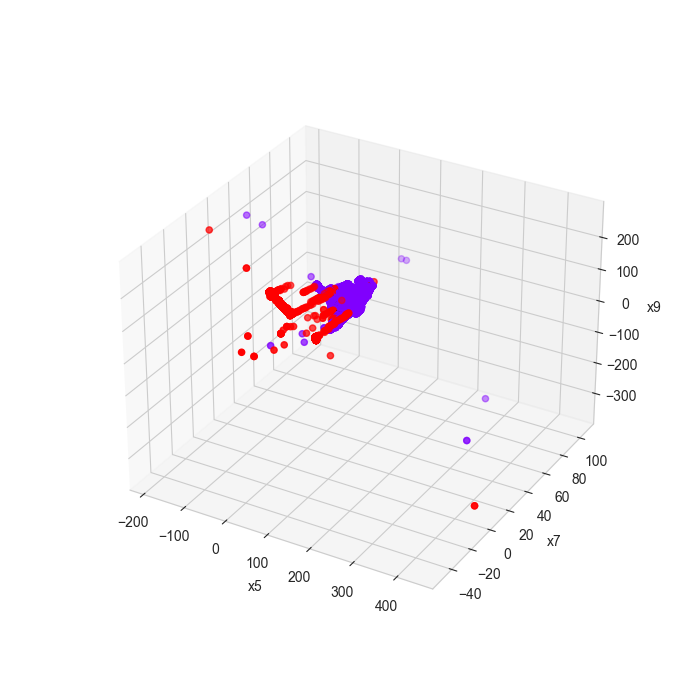

In [23]:
plot_3d(shuttle, dims=(4, 6, 8))

## Vowels dataset

In [24]:
vowels = datasets["vowels"]
vowels.x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.580,-0.903,0.618,-0.998,-2.464,-0.846,2.350,0.375,-0.649,1.605,-0.623,-0.383
1,0.784,-1.077,0.616,-0.922,-2.389,-0.638,2.107,0.361,-0.714,1.260,-0.423,-0.288
2,0.791,-1.086,0.670,-0.806,-2.261,-0.538,2.053,0.266,-0.843,1.082,-0.267,-0.172
3,1.217,-1.083,0.855,-0.725,-2.156,-0.102,1.769,0.303,-1.045,0.655,0.214,-0.342
4,1.065,-1.030,0.773,-0.452,-1.956,0.248,1.530,0.254,-0.969,-0.208,0.332,0.007


In [25]:
vowels.x.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,1.456e+03,1.456e+03,1.456e+03,1.456e+03,1.456e+03,1.456e+03,1.456e+03,1.456e+03,1.456e+03,1.456e+03,1.456e+03,1.456e+03
mean,1.074e-15,-2.928e-15,3.123e-16,7.320e-16,8.589e-16,7.808e-17,-8.979e-16,2.147e-16,-1.093e-15,2.089e-15,1.269e-16,4.880e-16
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00
min,-2.867e+00,-2.699e+00,-2.205e+00,-2.184e+00,-3.135e+00,-3.488e+00,-3.043e+00,-2.329e+00,-1.672e+00,-3.077e+00,-3.365e+00,-3.175e+00
25%,-7.031e-01,-7.996e-01,-8.437e-01,-8.071e-01,-6.359e-01,-6.555e-01,-6.193e-01,-7.640e-01,-9.560e-01,-6.758e-01,-5.771e-01,-5.839e-01
50%,1.274e-02,-4.553e-02,1.080e-01,-3.226e-02,5.695e-02,5.198e-02,-1.074e-01,-3.720e-02,-6.761e-02,-3.925e-02,9.032e-02,8.078e-02
75%,7.163e-01,8.467e-01,8.512e-01,7.889e-01,7.765e-01,7.108e-01,5.367e-01,6.625e-01,8.736e-01,6.606e-01,7.174e-01,6.743e-01
max,3.647e+00,2.307e+00,2.255e+00,2.911e+00,2.689e+00,3.036e+00,3.561e+00,3.223e+00,2.538e+00,3.933e+00,2.362e+00,3.209e+00


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>,
        <Axes: title={'center': 'x7'}>, <Axes: title={'center': 'x8'}>,
        <Axes: title={'center': 'x9'}>, <Axes: title={'center': 'x10'}>,
        <Axes: title={'center': 'x11'}>, <Axes: title={'center': 'x12'}>]],
      dtype=object)

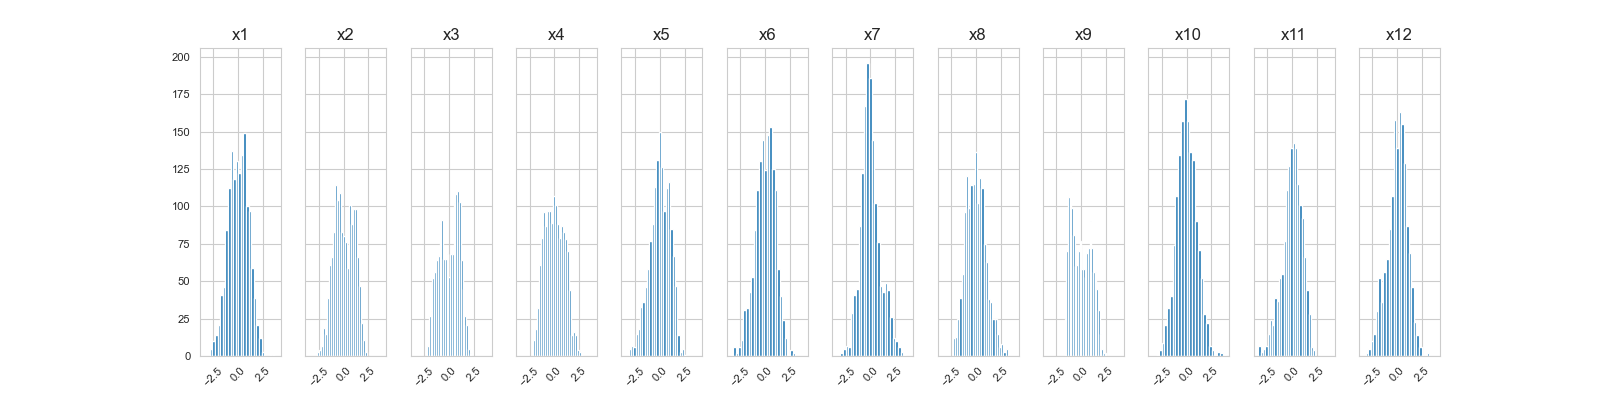

In [70]:
vowels.x.hist(figsize=(16, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 12), sharey=True, sharex=True)

In [27]:
vowels.y.describe()

,class
count,1456.000
mean,0.034
std,0.182
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [28]:
shuttle.y.value_counts()

class
0        45586
1         3511
Name: count, dtype: int64

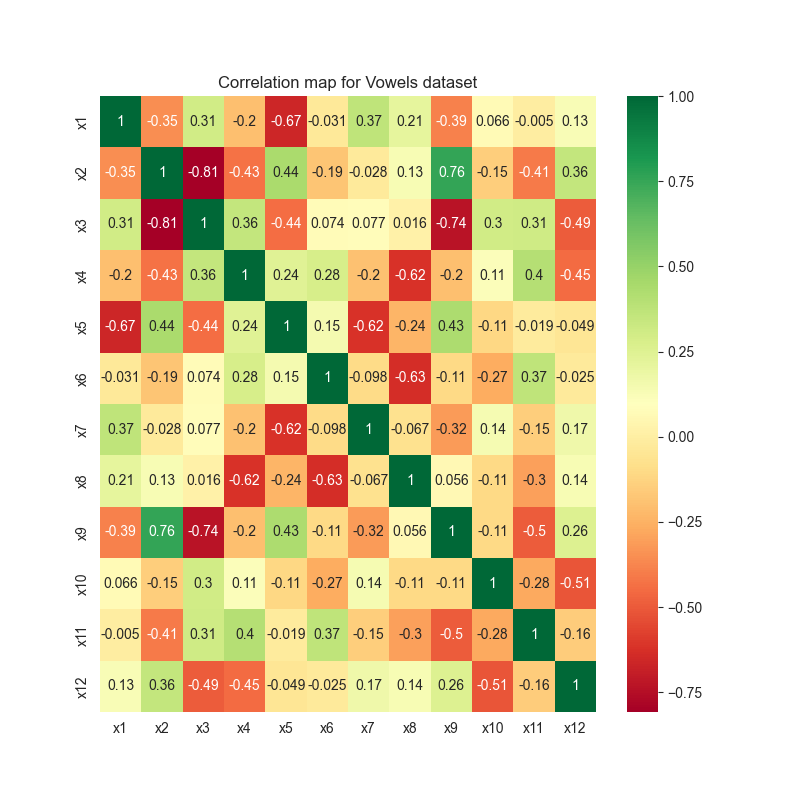

In [64]:
corr_map_plot(vowels, figsize=(8, 8))

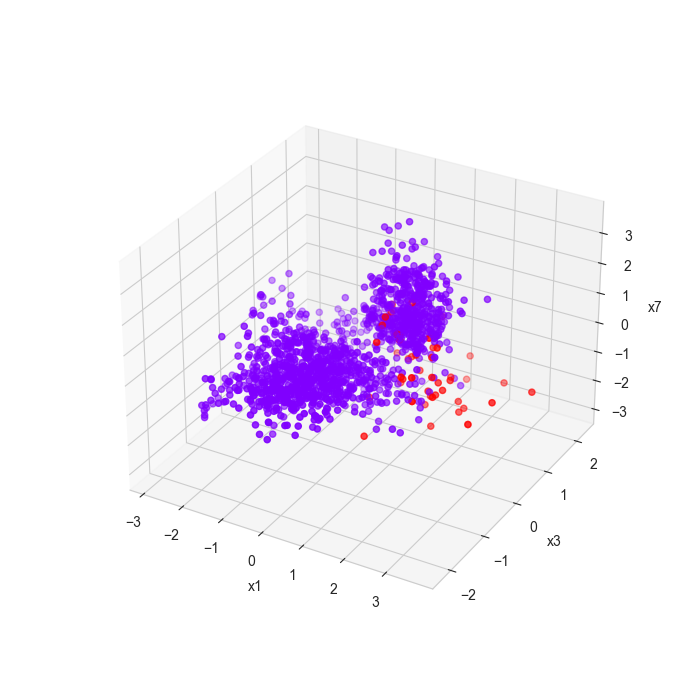

In [30]:
plot_3d(vowels, dims=(0, 2, 6))

# Experiments

## Local Outlier Factor

In [31]:
def preprocess_y(y: np.ndarray):
    return np.where(y == 1, 0, 1)

In [61]:
def local_outlier_factor(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = LocalOutlierFactor(n_neighbors=20, contamination='auto', leaf_size=30, p=5)
    # model = LocalOutlierFactor(
    #     n_neighbors=20, algorithm='auto',
    #     leaf_size=30, metric='minkowski',
    #     p=2, metric_params=None, contamination='auto'
    # )
    model.fit(dataset.x_train)
    dataset.y_pred = DataFrame(preprocess_y(model.fit_predict(dataset.x_test)), columns=["class"])
    dataset.scores_pred = DataFrame(model.negative_outlier_factor_)

Accuracy Score : 0.9129088761253005
Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     22769
           1       0.24      0.09      0.13      1780

    accuracy                           0.91     24549
   macro avg       0.58      0.53      0.54     24549
weighted avg       0.88      0.91      0.89     24549

****************************************** DATASET VOWELS ******************************************

Accuracy Score : 0.9697802197802198
Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       707
           1       0.43      0.14      0.21        21

    accuracy                           0.97       728
   macro avg       0.70      0.57      0.60       728
weighted avg       0.96      0.97      0.96       728

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9

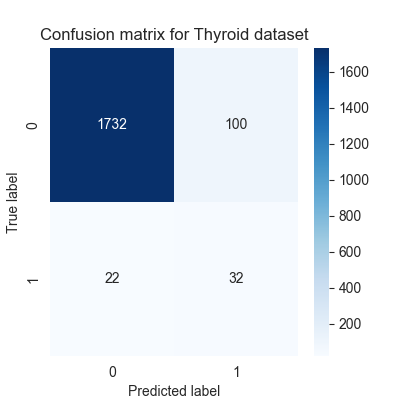

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.9148641492525154
Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.98      0.96     22784
           1       0.24      0.09      0.13      1765

    accuracy                           0.91     24549
   macro avg       0.59      0.53      0.54     24549
weighted avg       0.88      0.91      0.90     24549



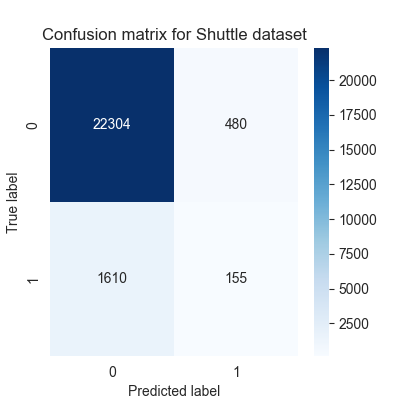

****************************************** DATASET VOWELS ******************************************

Accuracy Score : 0.978021978021978
Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       713
           1       0.44      0.27      0.33        15

    accuracy                           0.98       728
   macro avg       0.71      0.63      0.66       728
weighted avg       0.97      0.98      0.98       728



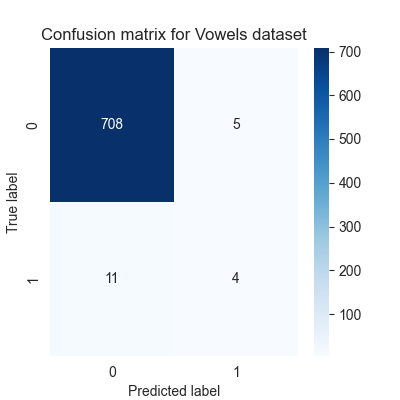

In [82]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for dataset in datasets.values():
    local_outlier_factor(dataset)
    accuracy_report(dataset)
    conf_matrix_plot(dataset)

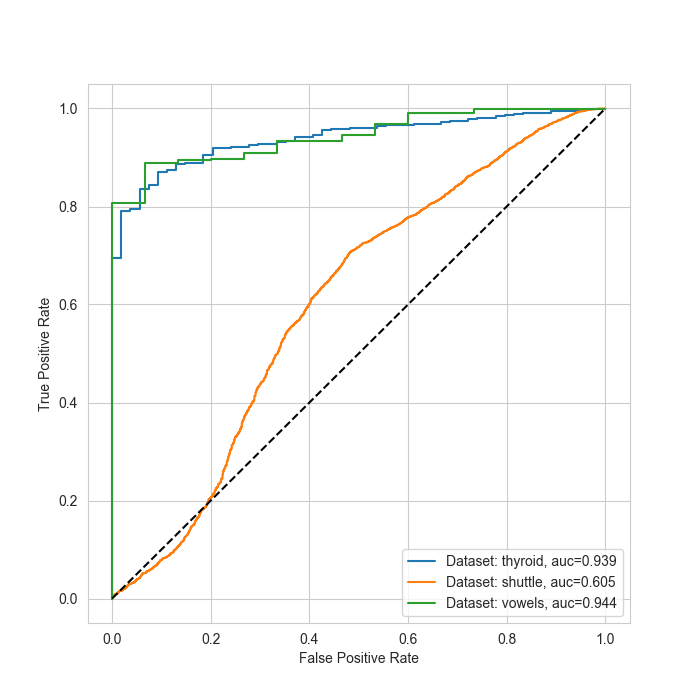

In [83]:
roc_curve_plot(datasets)

# Isolation Forest

In [79]:
def isolation_forest(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = IsolationForest(
        n_estimators=200,
        max_samples="auto",
        contamination="auto"
    )
    model.fit(dataset.x)
    dataset.y_pred = DataFrame(preprocess_y(model.predict(dataset.x_test)))
    dataset.scores_pred = DataFrame(model.decision_function(dataset.x_test))


***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9241781548250265
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      1833
           1       0.26      0.92      0.41        53

    accuracy                           0.92      1886
   macro avg       0.63      0.92      0.68      1886
weighted avg       0.98      0.92      0.94      1886



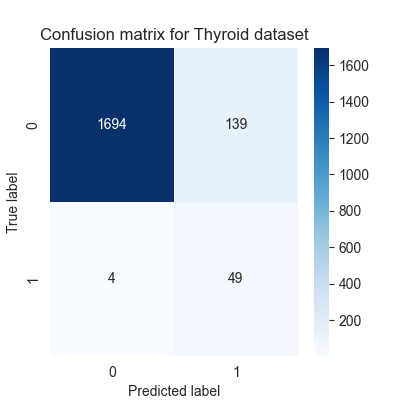

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.9351501079473705
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     22780
           1       0.53      0.98      0.69      1769

    accuracy                           0.94     24549
   macro avg       0.76      0.96      0.83     24549
weighted avg       0.96      0.94      0.94     24549



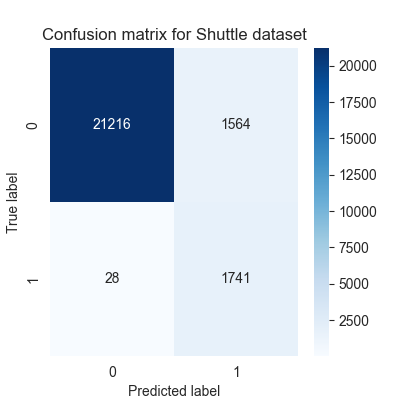

****************************************** DATASET VOWELS ******************************************

Accuracy Score : 0.8942307692307693
Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       705
           1       0.09      0.26      0.13        23

    accuracy                           0.89       728
   macro avg       0.53      0.59      0.54       728
weighted avg       0.95      0.89      0.92       728



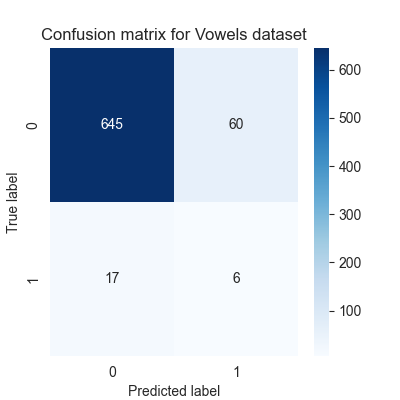

In [80]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for name, dataset in datasets.items():
    isolation_forest(dataset)
    accuracy_report(dataset)
    conf_matrix_plot(dataset)

#### ROC curve

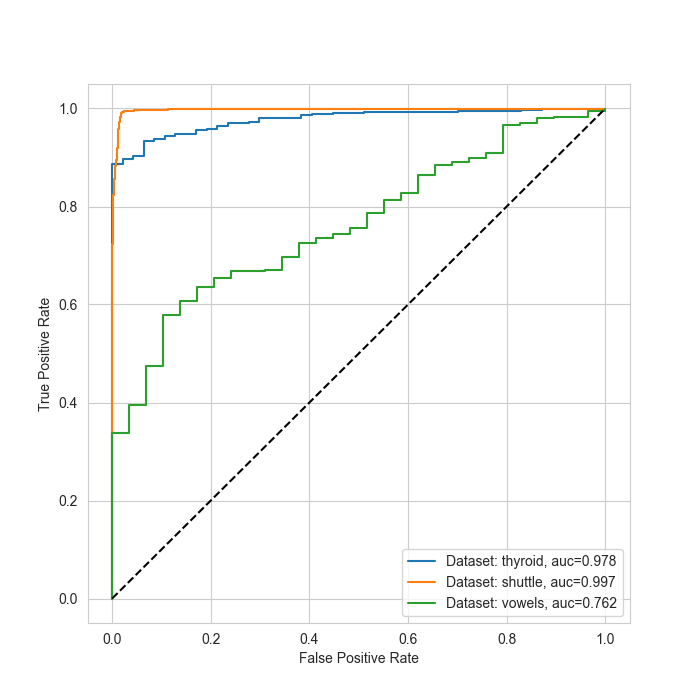

In [78]:
roc_curve_plot(datasets)

## k-Nearest Neighbors

In [145]:
def knn2(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")

    model = NearestNeighbors(n_neighbors=5)
    model.fit(dataset.x)

    # distances and indexes of k-neaighbors from model outputs
    distances, indexes = model.kneighbors(dataset.x)
    # plot mean of k-distances of each observation
    plt.plot(distances.mean(axis=1))
    # dataset.y_pred = DataFrame(preprocess_y(model.predict(dataset.x)))
    # dataset.scores_pred = model.predict_proba(dataset.x)[:, 1]
    print(distances)
    print(indexes)
    outlier_index = np.where(distances.mean(axis=1) > 0.15)
    # print(outlier_index)
    # dataset.y_pred = dataset.y.to_numpy().copy()[:] = 0
    # dataset.y_pred[outlier_index] = 1
    accuracy_report(dataset)

In [204]:
def knn(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = NearestNeighbors(n_neighbors=20, p=5)
    model.fit(dataset.x_train)

    distances, indexes = model.kneighbors(dataset.x_test)
    dataset.scores_pred = DataFrame(np.mean(distances, axis=1))
    threshold = np.percentile(dataset.scores_pred, 95)
    dataset.y_pred = DataFrame(np.where(dataset.scores_pred > threshold, 1, 0))

In [205]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for name, dataset in datasets.items():
    knn(dataset)
    accuracy_report(dataset)

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.954931071049841
Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1840
           1       0.29      0.61      0.40        46

    accuracy                           0.95      1886
   macro avg       0.64      0.79      0.69      1886
weighted avg       0.97      0.95      0.96      1886

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.91197197441851
Classification Report :
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     22810
           1       0.33      0.23      0.27      1739

    accuracy                           0.91     24549
   macro avg       0.64      0.60      0.61     24549
weighted avg       0.90      0.91      0.90     24549

***********************

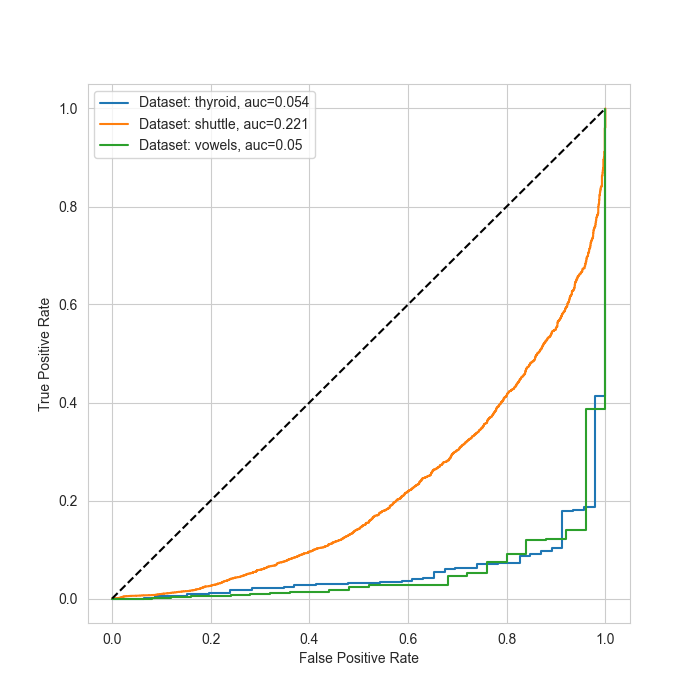

In [207]:
roc_curve_plot(datasets)

## One-Class SVM

In [222]:
def svm(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = OneClassSVM(kernel='rbf', nu=0.2, gamma="auto", max_iter=1000, shrinking=True, tol=0.001, verbose=False)
    model.fit(dataset.x_train)

    dataset.scores_pred = DataFrame(model.decision_function(dataset.x_test))

    threshold = np.percentile(dataset.scores_pred, 95)
    dataset.y_pred = DataFrame(np.where(dataset.scores_pred > threshold, 1, 0))

In [223]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for name, dataset in datasets.items():
    svm(dataset)
    accuracy_report(dataset)

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9220572640509014
Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1834
           1       0.00      0.00      0.00        52

    accuracy                           0.92      1886
   macro avg       0.49      0.47      0.48      1886
weighted avg       0.94      0.92      0.93      1886

***************************************** DATASET SHUTTLE ******************************************



C:\Users\andrii\AppData\Local\pypoetry\Cache\virtualenvs\anomalydetectionict-i9oc49El-py3.10\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score : 0.8793026192512934
Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     22798
           1       0.01      0.00      0.01      1751

    accuracy                           0.88     24549
   macro avg       0.47      0.48      0.47     24549
weighted avg       0.86      0.88      0.87     24549

****************************************** DATASET VOWELS ******************************************

Accuracy Score : 0.9175824175824175
Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       705
           1       0.00      0.00      0.00        23

    accuracy                           0.92       728
   macro avg       0.48      0.47      0.48       728
weighted avg       0.94      0.92      0.93       728



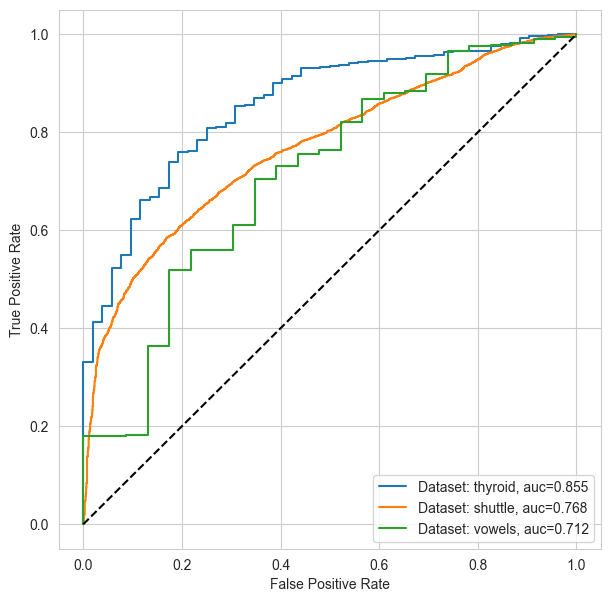

In [224]:
roc_curve_plot(datasets)